# Brain MRI Segmentation
***Predict Brain Tissue Segmentation Masks from Brain MRI Scans***

## Contents

1. [Background](#Background)
1. [Exploratory Data Analyis & Pre-processing](#Exploratory-Data-Analysis-&-Pre-processing)
1. [Train Models on Sagemaker](#Train-Models-on-SageMaker)
1. [Inference Endpoints](#Inference-Endpoints)
1. [Model Evaluation](#Model-Evaluation)
1. [Extensions](#Extensions)

## Background

This notebook shows how to apply image segmentation algorithms to medical imaging use-cases in a simple, streamlined way using Amazon SageMaker. Specifically, we'll be using Amazon SageMaker Built-in semantic segmentation algorithm to train a convolutional neural network for semantic segmentation on SageMaker. Put simply, the goal of semantic segmentation is to make classifications on an image at the pixel-level, producing a classification "mask." We will train a model. We'll show how to deploy the model to inference endpoint in the cloud with Amazon SageMaker fully managed hosting service.

### Use-case

Medical imaging techniques allow medical professionals to see inside the human body, but more often than not the professional needs precise segmentation of the tissues within the image for analytical procedures and inferences. This is particular relevant in use-cases where volumetric and surface analysis are key to derive insights from the raw imaging, such as assessing the cardivascular health of a patient. Typically, this segmentation is done manually by medical professionals, and is very time consuming. Recently, convolutional neural networks have been shown to be highly performant at this task, and in this notebook we'll train a network to automatically segment brain tissue from MRI images.

### Dataset

In this notebook, we'll be using Brain MRI data from the [Open Access Series of Imaging Studies (OASIS)](http://www.oasis-brains.org/). This project offers a wealth of neuroimaging datasets; we'll be looking at a small subset of cross-sectional brain MRIs. This set consists of a cross-sectional collection of 416 subjects aged 18 to 96. For each subject, 3 or 4 individual T1-weighted MRI scans obtained in single scan sessions are included. The subjects are all right-handed and include both men and women. 100 of the included subjects over the age of 60 have been clinically diagnosed with very mild to moderate Alzheimer’s disease (AD). Additionally, a reliability data set is included containing 20 nondemented subjects imaged on a subsequent visit within 90 days of their initial session.


In this tutorial, I'll be using the [oasis_cross-sectional_disc1.tar.gz](https://download.nrg.wustl.edu/data/oasis_cross-sectional_disc1.tar.gz) file from the [OASIS-1](http://www.oasis-brains.org/#data) data set.

### Permissions

For this notebook, in addition to s3 bucket access, you will need Elastic Container Registry access. Please go to IAM console to add `AmazonEC2ContainerRegistryFullAccess` to the IAM role for your notebook instance.

## Exploratory Data Analysis & Pre-processing

In this section, we'll visualize the data and pre-process it for training a segmentation network. Once completed, we'll put the pre-processed data on S3 for SageMaker to use during model training.

### Setup

We'll start by: 
- Importing the libraries necessary to perform the data visualization.
- Setting the S3 bucket and prefixes that you use for training and model data. Use the default bucket specified by the Amazon SageMaker session.
- The IAM role ARN used to give processing and training access to the dataset.

In [ ]:
!pip install nibabel

In [61]:
import numpy as np
from PIL import Image
import boto3
import io
import os
from glob import glob
import imageio
import time
import urllib
import tarfile
import shutil
import json
import matplotlib.pyplot as plt
import nibabel as nib
%matplotlib inline

In [3]:
import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()
role = get_execution_role()

s3 = boto3.client('s3')

In [7]:
data_bucket = 'sagemaker-us-west-2-029454422462' # '<your-bucket-name>'
data_prefix = 'OASIS-20200326' 
data_dir = '/home/ec2-user/SageMaker/oasis'

In [5]:
def create_dir_if_not_exist(d):
    if not os.path.exists(d):
        os.mkdir(d)

Now we can download and extract.

create_dir_if_not_exist(os.path.join(data_dir, 'brain_mri'))

!wget https://download.nrg.wustl.edu/data/oasis_cross-sectional_disc1.tar.gz -P /home/ec2-user/SageMaker/oasis/
    
with tarfile.open(os.path.join(data_dir, 'oasis_cross-sectional_disc1.tar.gz')) as tar:
    tar.extractall(os.path.join(data_dir, 'brain_mri'))

### Visualization

Let's download a pair of cross-sectional brain MRI/mask from s3 into memory. Although organ tissue segmentation is inherently a three-dimensional task, we’ll approximate it by segmenting 2-D cross-sectional MRI slices. This is less complex and compute-intensive than volumetric segmentation and performs reasonably well.

Let's look at such a slice:

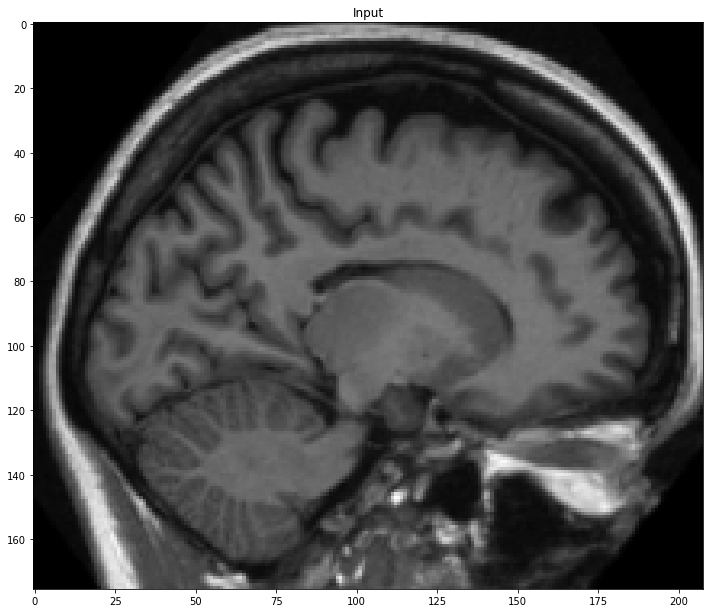

In [5]:
fname = os.path.join(data_dir, 'brain_mri','disc1','OAS1_0002_MR1','PROCESSED','MPRAGE','T88_111',
                     'OAS1_0002_MR1_mpr_n4_anon_111_t88_gfc.img')
nii = nib.load(fname)
image = nii.get_fdata().squeeze()

plt.figure(figsize=(12, 12))
plt.title('Input')
plt.imshow(np.rot90(image[101, :, :]), cmap=plt.cm.gray)

In order to train a segmentation network, we need ground-truth segmentation masks for the tissue. Fortunately, the data set comes with such masks hand-annotated by medical professionals:

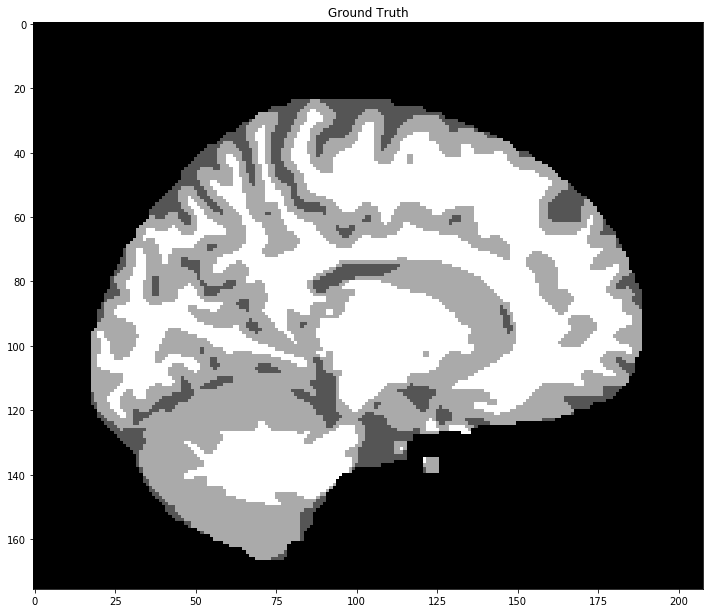

In [6]:
fname = os.path.join(data_dir, 'brain_mri','disc1','OAS1_0002_MR1','FSL_SEG',
                     'OAS1_0002_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg.img')
nii_segmentation = nib.load(fname)
segmentation = nii_segmentation.get_fdata().squeeze()

plt.figure(figsize=(12, 12))
plt.title('Ground Truth')
plt.imshow(np.rot90(segmentation[101, :, :]), cmap=plt.cm.gray)

### Upload the images to s3

In [10]:
%time
s3_original_data = sagemaker_session.upload_data(path=os.path.join(data_dir, 'brain_mri', 'disc1'), 
                                                 key_prefix=os.path.join(data_prefix, 'brain_mri', 'disc1'), 
                                                 bucket = data_bucket)

### Pre-processing and file directory structure

Now that we've seen the data, we need to pre-process it to train our network on it. 

First, we're going to split the data into a training and validation set (80/20) **by patient**. This is important to remove any possibility of **data leakage**; neighboring brain MRI slices will correlate and splitting by patient ensures clean validation.

In order to pre-process the MRI images, we need to convert them from their native format to arrays that we can save as png images. 

The raw MRI arrays have values that represent radiological intensities. These have a far wider range than pixel intensities, and are loaded into memory as uint16. Upon saving the slices as png's, the data is scaled to fall on the \[0,255\] range of uint8.

Next, we're going to load each image and mask slice into memory, pre-process them, and save them to disk as individual image files into respective training and validation directories. This is quite simply, moving the training images to train directory and so on. See the link for more information. https://docs.aws.amazon.com/sagemaker/latest/dg/semantic-segmentation.html#semantic-segmentation-inputoutput

```
s3://bucket_name
    |
    |- train
                 |
                 | - 0000.jpg
                 | - coffee.jpg
    |- validation
                 |
                 | - 00a0.jpg
                 | - bananna.jpg              
    |- train_annotation
                 |
                 | - 0000.png
                 | - coffee.png
    |- validation_annotation
                 |
                 | - 00a0.png   
                 | - bananna.png 
    |- label_map
                 | - train_label_map.json  
                 | - validation_label_map.json 
```

Notice also that all the images in the `_annotation` directory are all indexed PNG files. This implies that the metadata (color mapping modes) of the files contain information on how to map the indices to colors and vice versa. Having an indexed PNG is an advantage as the images will be rendered by image viewers as color images, but the image themsevels only contain integers. The integers are also within `[0, 1 ... c-1, 255]`  for a `c` class segmentation problem, with `255` as 'hole' or 'ignore' class. We allow any mode that is a [recognized standard](https://pillow.readthedocs.io/en/3.0.x/handbook/concepts.html#concept-modes) as long as they are read as integers.

While we recommend the format with default color mapping modes, we also allow the customers to specify their own label maps. Refer to the [documentation](Permalink-to-label-map-documentation-section) for more details. The label map for OASIS dataset, is the default (which we use incase no label maps are provided): 
```json
{
    "scale": 1
}```

This essentially tells us to simply use the images as read as integers as labels directly. Let us create (recreate the default just for demonstration) label map for training channel and let the algorithm use the default (which is exactly the same for the validation channel). If `label_map` is used, please pass it to the label_map channel.


## SageMaker Processing

With Amazon SageMaker Processing jobs, you can leverage a simplified, managed experience to run data pre- or post-processing and model evaluation workloads with computing resource you need for the job on the Amazon SageMaker platform.

A processing job downloads input from Amazon Simple Storage Service (Amazon S3), then uploads outputs to Amazon S3 during or after the processing job.

<img src="Processing-1.jpg">

We will walk through how to create a processing container, and how to use a `ScriptProcessor` to run your own code within a container. Create a custom container and run a processing job using the `processing_script.py` script below. You can provide your own dependencies inside this container to run your processing script with.

In [97]:
!pygmentize docker/Dockerfile

FROM python:3.6-slim-buster

# Install libraries
RUN pip3 install imageio==2.3.0 numpy==1.16.4 nibabel==3.0.2 scikit-learn==0.20.3 pillow==5.1.0

# Add a python script and configure Docker to run it
ADD processing_script.py /
ENTRYPOINT ["python3", "/processing_script.py"]


In [96]:
!pygmentize docker/processing_script.py

import numpy as np
import os, sys
from glob import glob
import imageio
from sklearn.model_selection import train_test_split
import nibabel as nib
import json

    
input_data_path = '/opt/ml/processing/input'
output_data_path = '/opt/ml/processing/output'

def create_dir_if_not_exist(d):
    if not os.path.exists(d):
        os.makedirs(d)

def process_mris(images, masks, target_dir, mask_dir):
    for idx, f in enumerate(images):
        # print(f)
        nii = nib.load(f)
        mris = nii.get_fdata().squeeze()[np.arange(1, nii.shape[0], 2), :, :]
        mris = mris / mris.max() * 255
        
        nii_mask = nib.load(masks[idx])
        segmentations = nii_mask.get_fdata().squeeze()[np.arange(1, nii.shape[0], 2), :, :]
        
        # dimension check
        if nii.shape != nii_mask.shape:
            print('Dimension of image and mask do not match. %s %s' % (nii.shape, nii_mask.shape))
            continue
            
        num_slices = mris.shape[0]
        for i in ra

This block of code builds the container using the `docker` command, creates an Amazon Elastic Container Registry (Amazon ECR) repository, and pushes the image to Amazon ECR.

In [44]:
import boto3
account_id = boto3.client('sts').get_caller_identity().get('Account')
region = boto3.session.Session().region_name

ecr_repository = 'sagemaker-brain-segmentation-processing'
tag = ':latest'
ecr_repository_uri = '{}.dkr.ecr.{}.amazonaws.com/{}'.format(account_id, region, ecr_repository + tag)

# build the docker image
!docker build -t $ecr_repository ./docker/

Sending build context to Docker daemon  6.144kB
Step 1/4 : FROM python:3.6-slim-buster
 ---> d3ae39a2a3a1
Step 2/4 : RUN pip3 install imageio==2.3.0 numpy==1.16.4 nibabel==3.0.2 scikit-learn==0.20.3 pillow==5.1.0
 ---> Running in f23c309e5094
Removing intermediate container f23c309e5094
 ---> b8a35be78d75
Step 3/4 : ADD processing_script.py /
 ---> bed2db8ffaed
Step 4/4 : ENTRYPOINT ["python3", "/processing_script.py"]
 ---> Running in 230d9139a893
Removing intermediate container 230d9139a893
 ---> e9f8ee4a51c8
Successfully built e9f8ee4a51c8
Successfully tagged sagemaker-brain-segmentation-processing:latest


In [45]:
# Create ECR repository and push docker image
!$(aws ecr get-login --region $region --registry-ids $account_id --no-include-email)
!aws ecr create-repository --repository-name $ecr_repository
!docker tag {ecr_repository + tag} $ecr_repository_uri
!docker push $ecr_repository_uri

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded

An error occurred (RepositoryAlreadyExistsException) when calling the CreateRepository operation: The repository with name 'sagemaker-brain-segmentation-processing' already exists in the registry with id '029454422462'
The push refers to repository [029454422462.dkr.ecr.us-west-2.amazonaws.com/sagemaker-brain-segmentation-processing]

167c19a3: Preparing 
ac665edd: Preparing 
88ba40ad: Preparing 
65ce8fdc: Preparing 
fa55df3b: Preparing 
a0723efa: Preparing 
ac665edd: Pushed     330MB/325.9MBAlatest: digest: sha256:30668bf511f2b67d0f243f113cb45d71807bda8b7a85531f904b6891ac08ab66 size: 1791


The `ScriptProcessor` class lets you run a command inside this container, which you can use to run your own script `processing_script.py`. This code is running inside of the Docker container you built in this notebook. You can add the dependencies to the Docker image, and run your own pre-processing, feature-engineering, and model evaluation scripts inside of this container.

In [46]:
from sagemaker.processing import ScriptProcessor, ProcessingInput, ProcessingOutput

%time 
processing_job_name = ecr_repository + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

image_processor = ScriptProcessor(base_job_name=processing_job_name,
                                  image_uri=ecr_repository_uri,
                                  command=['python3'],
                                  role=role,
                                  instance_count=1,
                                  instance_type='ml.c4.xlarge',
                                  max_runtime_in_seconds=3600,)

image_processor.run(code='docker/processing_script.py',
                    inputs=[ProcessingInput(source='s3://%s/%s' % (data_bucket, data_prefix),
                                            destination='/opt/ml/processing/input')],
                    outputs=[ProcessingOutput(output_name='train',
                                  source='/opt/ml/processing/output/train',
                                  s3_upload_mode='Continuous'),
                             ProcessingOutput(output_name='validation',
                                  source='/opt/ml/processing/output/validation'),
                             ProcessingOutput(output_name='train_annotation',
                                  source='/opt/ml/processing/output/train_annotation'),
                             ProcessingOutput(output_name='validation_annotation',
                                  source='/opt/ml/processing/output/validation_annotation'),                             ProcessingOutput(output_name='label_map',
                                  source='/opt/ml/processing/output/label_map',)])


Job Name:  sagemaker-brain-segmentation-processing-2020-03-27-00-53-29-047
Inputs:  [{'InputName': 'input-1', 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-029454422462/OASIS-20200326', 'LocalPath': '/opt/ml/processing/input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-029454422462/sagemaker-brain-segmentation-processing-2020-03-27-00-53-29-047/input/code/processing_script.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'train', 'S3Output': {'S3Uri': 's3://sagemaker-us-west-2-029454422462/sagemaker-brain-segmentation-processing-2020-03-27-00-53-29-047/output/train', 'LocalPath': '/opt/ml/processing/output/train', 'S3UploadMode': 'Continuous'}}, {'OutputName': 'validation', 'S3Output':

OAS1_0003_MR1_mpr_n4_anon_111_t88_62.png: 217
OAS1_0003_MR1_mpr_n4_anon_111_t88_63.png: 212
OAS1_0003_MR1_mpr_n4_anon_111_t88_64.png: 208
OAS1_0003_MR1_mpr_n4_anon_111_t88_65.png: 209
OAS1_0003_MR1_mpr_n4_anon_111_t88_66.png: 204
OAS1_0003_MR1_mpr_n4_anon_111_t88_67.png: 209
OAS1_0003_MR1_mpr_n4_anon_111_t88_68.png: 212
OAS1_0003_MR1_mpr_n4_anon_111_t88_69.png: 202
OAS1_0003_MR1_mpr_n4_anon_111_t88_70.png: 206
OAS1_0003_MR1_mpr_n4_anon_111_t88_71.png: 207
OAS1_0003_MR1_mpr_n4_anon_111_t88_72.png: 193
OAS1_0003_MR1_mpr_n4_anon_111_t88_73.png: 201
OAS1_0003_MR1_mpr_n4_anon_111_t88_74.png: 187
OAS1_0003_MR1_mpr_n4_anon_111_t88_75.png: 209
OAS1_0003_MR1_mpr_n4_anon_111_t88_76.png: 223
OAS1_0003_MR1_mpr_n4_anon_111_t88_77.png: 221
OAS1_0003_MR1_mpr_n4_anon_111_t88_78.png: 219
OAS1_0003_MR1_mpr_n4_anon_111_t88_79.png: 215
OAS1_0003_MR1_mpr_n4_anon_111_t88_80.png: 209
OAS1_0003_MR1_mpr_n4_anon_111_t88_81.png: 158
OAS1_0003_MR1_mpr_n4_anon_111_t88_82.png: 69
OAS1_0003_MR1_mpr_n4_anon_111_t88_8

OAS1_0018_MR1_mpr_n4_anon_111_t88_54.png: 196
OAS1_0018_MR1_mpr_n4_anon_111_t88_55.png: 200
OAS1_0018_MR1_mpr_n4_anon_111_t88_56.png: 202
OAS1_0018_MR1_mpr_n4_anon_111_t88_57.png: 205
OAS1_0018_MR1_mpr_n4_anon_111_t88_58.png: 204
OAS1_0018_MR1_mpr_n4_anon_111_t88_59.png: 217
OAS1_0018_MR1_mpr_n4_anon_111_t88_60.png: 196
OAS1_0018_MR1_mpr_n4_anon_111_t88_61.png: 196
OAS1_0018_MR1_mpr_n4_anon_111_t88_62.png: 195
OAS1_0018_MR1_mpr_n4_anon_111_t88_63.png: 192
OAS1_0018_MR1_mpr_n4_anon_111_t88_64.png: 188
OAS1_0018_MR1_mpr_n4_anon_111_t88_65.png: 197
OAS1_0018_MR1_mpr_n4_anon_111_t88_66.png: 199
OAS1_0018_MR1_mpr_n4_anon_111_t88_67.png: 203
OAS1_0018_MR1_mpr_n4_anon_111_t88_68.png: 197
OAS1_0018_MR1_mpr_n4_anon_111_t88_69.png: 197
OAS1_0018_MR1_mpr_n4_anon_111_t88_70.png: 188
OAS1_0018_MR1_mpr_n4_anon_111_t88_71.png: 182
OAS1_0018_MR1_mpr_n4_anon_111_t88_72.png: 199
OAS1_0018_MR1_mpr_n4_anon_111_t88_73.png: 202
OAS1_0018_MR1_mpr_n4_anon_111_t88_74.png: 200
OAS1_0018_MR1_mpr_n4_anon_111_t88_

OAS1_0032_MR1_mpr_n4_anon_111_t88_46.png: 208
OAS1_0032_MR1_mpr_n4_anon_111_t88_47.png: 206
OAS1_0032_MR1_mpr_n4_anon_111_t88_48.png: 204
OAS1_0032_MR1_mpr_n4_anon_111_t88_49.png: 205
OAS1_0032_MR1_mpr_n4_anon_111_t88_50.png: 208
OAS1_0032_MR1_mpr_n4_anon_111_t88_51.png: 208
OAS1_0032_MR1_mpr_n4_anon_111_t88_52.png: 209
OAS1_0032_MR1_mpr_n4_anon_111_t88_53.png: 230
OAS1_0032_MR1_mpr_n4_anon_111_t88_54.png: 215
OAS1_0032_MR1_mpr_n4_anon_111_t88_55.png: 231
OAS1_0032_MR1_mpr_n4_anon_111_t88_56.png: 222
OAS1_0032_MR1_mpr_n4_anon_111_t88_57.png: 194
OAS1_0032_MR1_mpr_n4_anon_111_t88_58.png: 193
OAS1_0032_MR1_mpr_n4_anon_111_t88_59.png: 203
OAS1_0032_MR1_mpr_n4_anon_111_t88_60.png: 196
OAS1_0032_MR1_mpr_n4_anon_111_t88_61.png: 185
OAS1_0032_MR1_mpr_n4_anon_111_t88_62.png: 188
OAS1_0032_MR1_mpr_n4_anon_111_t88_63.png: 183
OAS1_0032_MR1_mpr_n4_anon_111_t88_64.png: 182
OAS1_0032_MR1_mpr_n4_anon_111_t88_65.png: 179
OAS1_0032_MR1_mpr_n4_anon_111_t88_66.png: 171
OAS1_0032_MR1_mpr_n4_anon_111_t88_

OAS1_0025_MR1_mpr_n4_anon_111_t88_38.png: 210
OAS1_0025_MR1_mpr_n4_anon_111_t88_39.png: 223
OAS1_0025_MR1_mpr_n4_anon_111_t88_40.png: 183
OAS1_0025_MR1_mpr_n4_anon_111_t88_41.png: 174
OAS1_0025_MR1_mpr_n4_anon_111_t88_42.png: 171
OAS1_0025_MR1_mpr_n4_anon_111_t88_43.png: 183
OAS1_0025_MR1_mpr_n4_anon_111_t88_44.png: 175
OAS1_0025_MR1_mpr_n4_anon_111_t88_45.png: 175
OAS1_0025_MR1_mpr_n4_anon_111_t88_46.png: 170
OAS1_0025_MR1_mpr_n4_anon_111_t88_47.png: 178
OAS1_0025_MR1_mpr_n4_anon_111_t88_48.png: 208
OAS1_0025_MR1_mpr_n4_anon_111_t88_49.png: 227
OAS1_0025_MR1_mpr_n4_anon_111_t88_50.png: 231
OAS1_0025_MR1_mpr_n4_anon_111_t88_51.png: 216
OAS1_0025_MR1_mpr_n4_anon_111_t88_52.png: 217
OAS1_0025_MR1_mpr_n4_anon_111_t88_53.png: 234
OAS1_0025_MR1_mpr_n4_anon_111_t88_54.png: 235
OAS1_0025_MR1_mpr_n4_anon_111_t88_55.png: 233
OAS1_0025_MR1_mpr_n4_anon_111_t88_56.png: 255
OAS1_0025_MR1_mpr_n4_anon_111_t88_57.png: 253
OAS1_0025_MR1_mpr_n4_anon_111_t88_58.png: 222
OAS1_0025_MR1_mpr_n4_anon_111_t88_

OAS1_0030_MR1_mpr_n4_anon_111_t88_34.png: 196
OAS1_0030_MR1_mpr_n4_anon_111_t88_35.png: 215
OAS1_0030_MR1_mpr_n4_anon_111_t88_36.png: 224
OAS1_0030_MR1_mpr_n4_anon_111_t88_37.png: 233
OAS1_0030_MR1_mpr_n4_anon_111_t88_38.png: 212
OAS1_0030_MR1_mpr_n4_anon_111_t88_39.png: 220
OAS1_0030_MR1_mpr_n4_anon_111_t88_40.png: 195
OAS1_0030_MR1_mpr_n4_anon_111_t88_41.png: 196
OAS1_0030_MR1_mpr_n4_anon_111_t88_42.png: 216
OAS1_0030_MR1_mpr_n4_anon_111_t88_43.png: 209
OAS1_0030_MR1_mpr_n4_anon_111_t88_44.png: 201
OAS1_0030_MR1_mpr_n4_anon_111_t88_45.png: 201
OAS1_0030_MR1_mpr_n4_anon_111_t88_46.png: 194
OAS1_0030_MR1_mpr_n4_anon_111_t88_47.png: 212
OAS1_0030_MR1_mpr_n4_anon_111_t88_48.png: 209
OAS1_0030_MR1_mpr_n4_anon_111_t88_49.png: 232
OAS1_0030_MR1_mpr_n4_anon_111_t88_50.png: 221
OAS1_0030_MR1_mpr_n4_anon_111_t88_51.png: 230
OAS1_0030_MR1_mpr_n4_anon_111_t88_52.png: 234
OAS1_0030_MR1_mpr_n4_anon_111_t88_53.png: 226
OAS1_0030_MR1_mpr_n4_anon_111_t88_54.png: 228
OAS1_0030_MR1_mpr_n4_anon_111_t88_

In [48]:
preprocessing_job_description = image_processor.jobs[-1].describe()

output_config = preprocessing_job_description['ProcessingOutputConfig']
for output in output_config['Outputs']:
    if output['OutputName'] == 'train':
        s3_train_data = output['S3Output']['S3Uri']
    if output['OutputName'] == 'train_annotation':
        s3_train_annotation = output['S3Output']['S3Uri']
    if output['OutputName'] == 'validation':
        s3_validation_data = output['S3Output']['S3Uri']
    if output['OutputName'] == 'validation_annotation':
        s3_validation_annotation = output['S3Output']['S3Uri']

Preprocessing is completed. Let's verify the processed png images are up on s3.

In [65]:
resource = boto3.resource('s3', region_name=region)
bucket = resource.Bucket(data_bucket)

validation_fname='/'.join(s3_validation_data.split('/')[3:]) + '/OAS1_0026_MR1_mpr_n3_anon_111_t88_41.png'
validation_obj = bucket.Object(validation_fname)
validation_mask_fname='/'.join(s3_validation_annotation.split('/')[3:]) + '/OAS1_0026_MR1_mpr_n3_anon_111_t88_41.png'
validation_mask_obj = bucket.Object(validation_mask_fname)

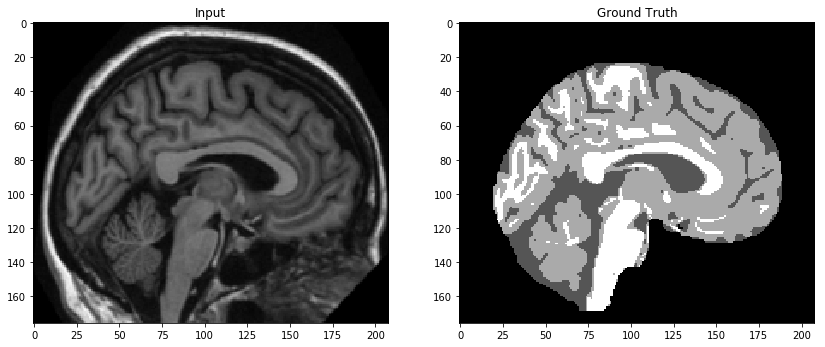

In [67]:
test_brain=imageio.imread(io.BytesIO(validation_obj.get()['Body'].read()))
test_mask=imageio.imread(io.BytesIO(validation_mask_obj.get()['Body'].read()))

plt.figure(figsize=(14, 14))
plt.subplot(121)
plt.title('Input')
plt.imshow(test_brain, cmap=plt.cm.gray)
plt.subplot(122)
plt.title('Ground Truth')
plt.imshow(test_mask, cmap=plt.cm.gray)

We need to keep track of number of training images. 

In [82]:
num_training_samples = len(list(bucket.objects.filter(Prefix='/'.join(s3_train_data.split('/')[3:])+'/')))

## Training
Now that we are done with all the setup that is needed, we are ready to train our built-in segmentation algorithm. To begin, let us create a ``sageMaker.estimator.Estimator`` object. This estimator will launch the training job. Let us use a nice-and-fast GPU instance (`ml.p3.2xlarge`) to train.

In [84]:
from sagemaker.amazon.amazon_estimator import get_image_uri
training_image = get_image_uri(sagemaker_session.boto_region_name, 'semantic-segmentation', repo_version="latest")
print (training_image)

433757028032.dkr.ecr.us-west-2.amazonaws.com/semantic-segmentation:latest


In [85]:
builtin_seg_job = 'DEMO-semantic-segmentation-job-' + \
    time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

s3_output_location='s3://{}/{}/{}'.format(data_bucket, data_prefix, builtin_seg_job)

# Create the sagemaker estimator object.
ss_model = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count = 1, 
                                         train_instance_type = 'ml.p3.2xlarge',
                                         train_volume_size = 50, # GB
                                         train_max_run = 360000, # seconds
                                         output_path = s3_output_location,
                                         base_job_name = builtin_seg_job,
                                         sagemaker_session = sagemaker_session)

The semantic segmentation algorithm at its core has two compoenents.

- An encoder or backbone network,
- A decoder or algorithm network. 

The encoder or backbone network is typically a regular convolutional neural network that may or maynot have had their layers pre-trained on an alternate task such as the [classification task of ImageNet images](http://www.image-net.org/). The Amazon SageMaker Semantic Segmentation algorithm comes with two choices of pre-trained or to be trained-from-scratch backbone networks ([ResNets](https://arxiv.org/abs/1512.03385) 50 or 101). 

The decoder is a network that picks up the outputs of one or many layers from the backbone and reconstructs the segmentation mask from it. Amazon SageMaker Semantic Segmentation algorithm comes with a choice of the [Fully-convolutional network (FCN)](https://arxiv.org/abs/1605.06211) or the [Pyramid scene parsing (PSP) network](https://arxiv.org/abs/1612.01105).

The algorithm also has ample options for hyperparameters that help configure the training job. The next step in our training, is to setup these networks and hyperparameters along with data channels for training the model. Consider the following example definition of hyperparameters. See the SageMaker Semantic Segmentation [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/semantic-segmentation.html) for more details on the hyperparameters.

One of the hyperparameters here for instance is the `epochs`. This defines how many passes of the dataset we iterate over and determines that training time of the algorithm. For the sake of demonstration let us run only `3` epochs. For more information on the hyperparameters of this algorithm, refer to the [documentation](perma-link-to-hyperparameter-section-in-documentation).

In [86]:
# Setup hyperparameters 
ss_model.set_hyperparameters(backbone='resnet-50', # This is the encoder. Other option is resnet-50
             algorithm='fcn', # This is the decoder. Other option is 'psp' and 'deeplab'                             
             use_pretrained_model='True', # Use the pre-trained model.
             crop_size=240, # Size of image random crop.                             
             num_classes=4, # white matter, gray matter, CSF, and background
             epochs=3, # Number of epochs to run.
             learning_rate=0.0001,                             
             optimizer='rmsprop', # Other options include 'adam', 'rmsprop', 'nag', 'adagrad'.
             lr_scheduler='poly', # Other options include 'cosine' and 'step'.                           
             mini_batch_size=16, # Setup some mini batch size.
             validation_mini_batch_size=16,
             early_stopping=False, # Turn on early stopping. If OFF, other early stopping parameters are ignored.                       
             num_training_samples=num_training_samples) # This is a mandatory parameter, 1464 in this case.
            # early_stopping_patience=2, # Tolerate these many epochs if the mIoU doens't increase.
            # early_stopping_min_epochs=10, # No matter what, run these many number of epochs. 

Now that the hyperparameters are setup, let us prepare the handshake between our data channels and the algorithm. To do this, we need to create the `sagemaker.session.s3_input` objects from our data channels. These objects are then put in a simple dictionary, which the algorithm uses to train.

In [87]:
# Create sagemaker s3_input objects
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                                        content_type='image/png', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', 
                                        content_type='image/png', s3_data_type='S3Prefix')
train_annotation = sagemaker.session.s3_input(s3_train_annotation, distribution='FullyReplicated', 
                                        content_type='image/png', s3_data_type='S3Prefix')
validation_annotation = sagemaker.session.s3_input(s3_validation_annotation, distribution='FullyReplicated', 
                                        content_type='image/png', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 
                 'validation': validation_data,
                 'train_annotation': train_annotation, 
                 'validation_annotation':validation_annotation}

We have our `Estimator` object, we have set the hyperparameters for this object and we have our data channels linked with the algorithm. The only remaining thing to do is to train the algorithm. The following command will train the algorithm. Training the algorithm involves a few steps. Firstly, the instances that we requested while creating the `Estimator` classes are provisioned and are setup with the appropriate libraries. Then, the data from our channels are downloaded into the instance. Once this is done, the training job begins. The provisioning and data downloading will take time, depending on the size of the data and the availability of the type of instances. Therefore it might be a few minutes before we start getting data logs for our training jobs. The data logs will also print out training loss on the training data, which is the pixel-wise cross-entropy loss as described in the algorithm papers. The data logs will also print out pixel-wise label accuracy and mean intersection-over-union (mIoU) on the validation data after a run of the dataset once or one epoch. These metrics measure the quality of the model under training.

Once the job has finished a "Job complete" message will be printed. The trained model can be found in the S3 bucket that was setup as `output_path` in the estimator.

In [88]:
ss_model.fit(inputs=data_channels, wait=True)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs
2020-03-27 03:29:30 Starting - Starting the training job...
2020-03-27 03:29:31 Starting - Launching requested ML instances.........
2020-03-27 03:31:05 Starting - Preparing the instances for training......
2020-03-27 03:32:11 Downloading - Downloading input data.........
2020-03-27 03:33:48 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
[03/27/2020 03:34:12 INFO 140048251062080] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'syncbn': u'False', u'gamma2': u'0.9', u'gamma1': u'0.9', u'early_stopping_min_epochs': u'5', u'epochs': u'10', u'_workers': u'16', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0001', u'crop_size': u'240', u'use_pretrained_model': u'True', u'_aux_weight': u'0.5', u'_hybrid': u'False', u'_augmentati

[03/27/2020 03:35:27 INFO 140048251062080] #progress_notice. epoch: 1, iterations: 20 speed: 58.021682199 samples/sec learning_rate: 0.000066
[03/27/2020 03:35:33 INFO 140048251062080] #progress_notice. epoch: 1, iterations: 40 speed: 58.0309642071 samples/sec learning_rate: 0.000062
[03/27/2020 03:35:38 INFO 140048251062080] #progress_notice. epoch: 1, iterations: 60 speed: 58.0319678454 samples/sec learning_rate: 0.000058
[03/27/2020 03:35:44 INFO 140048251062080] #progress_notice. epoch: 1, iterations: 80 speed: 57.9416291448 samples/sec learning_rate: 0.000054
[03/27/2020 03:35:49 INFO 140048251062080] #progress_notice. epoch: 1, iterations: 100 speed: 58.2434532504 samples/sec learning_rate: 0.000051
[03/27/2020 03:35:55 INFO 140048251062080] #progress_notice. epoch: 1, iterations: 120 speed: 58.0513448659 samples/sec learning_rate: 0.000047
[03/27/2020 03:36:01 INFO 140048251062080] #progress_notice. epoch: 1, iterations: 140 speed: 57.9951570502 samples/sec learning_rate: 0.0000

With 3 epochs, we are getting validation mIOU 0.632 and validation pixel accuracy 0.89. This is by no means a good segmentation model. But the purpose of this lab is to demonstrate end-to-end capability of SageMaker and how it is to start a complicated semantic segmentation neural network model training.

# Hosting
Once the training is done, we can deploy the trained model as an Amazon SageMaker hosted endpoint. This will allow us to make predictions (or inference) from the model. Note that we don't have to host on the same instance (or type of instance) that we used to train. Training is a prolonged and compute heavy job that require a different of compute and memory requirements that hosting typically do not. We can choose any sagemaker supported instance we want to host the model. In our case we chose the `ml.p3.2xlarge` instance to train, but we choose to host the model on the less expensive cpu instance, `ml.c5.xlarge`. The `deploy()` method returns a <tt>predictor</tt>, which we can use to submit requests to the endpoint. An endpoint is a containerized application serving inference using your model artifact.

The endpoint deployment can be accomplished as follows, which might take a couple of minutes.

In [89]:
ss_predictor = ss_model.deploy(instance_type='ml.c5.xlarge', initial_instance_count=1,
                               endpoint_name=builtin_seg_job)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs
-------------!

## Inference
Now that the trained model is deployed at an endpoint that is up-and-running, we can use this endpoint for inference. Let's use previsouly loaded brain image for inference:

In [90]:
ss_predictor.content_type = 'image/jpeg'
ss_predictor.accept = 'image/png'

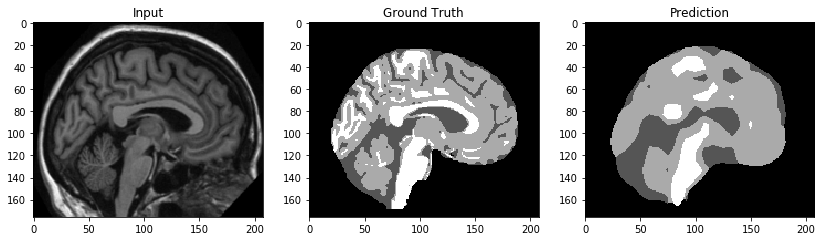

In [94]:
response = ss_predictor.predict(io.BytesIO(validation_obj.get()['Body'].read()))
output = np.array(imageio.imread(io.BytesIO(response)))
plt.figure(figsize=(14, 14))
plt.subplot(131)
plt.title('Input')
plt.imshow(test_brain, cmap=plt.cm.gray)
plt.subplot(132)
plt.title('Ground Truth')
plt.imshow(test_mask, cmap=plt.cm.gray)
plt.subplot(133)
plt.title('Prediction')
plt.imshow(output, cmap=plt.cm.gray)

This is what a mIOU 0.632 on this validation sample. Not particularly impressive but it is a good starting point given how few epochs it has run. For comparison, we ran another experiment with the following Estimator setup:

```python
ss_model.set_hyperparameters(... \
                     epochs=50,                         
                     optimizer='adam', 
                     early_stopping=True, # Turn on early stopping. 
                     early_stopping_patience=5, # Tolerate these many epochs if the mIoU doens't increase.
                     early_stopping_min_epochs=25) # No matter what, run these many number of epochs. 
```

And we achieved validation mIOU 0.729 and validation pixel accuracy 0.929. Actually, it only ran 30 epochs with the early stopping criteria we set. The job ran 41 minutes. Below is a snapshot of how that model performs on the same validation sample.

![segmentation_50epochs](segmentation_50epochs.png)

**Note**: To avoid unnecessary usage, make sure to delete your endpoints.

In [95]:
ss_predictor.delete_endpoint()

## Acknowledgements

This work was made possible with data provided by Open Access Series of Imaging Studies (OASIS), OASIS-1, by Marcus et al, 2007, used under CC BY 4.0.

Data were provided by OASIS:
-	OASIS-3: Principal Investigators: T. Benzinger, D. Marcus, J. Morris; NIH P50AG00561, P30NS09857781, P01AG026276, P01AG003991, R01AG043434, UL1TR000448, R01EB009352. AV-45 doses were provided by Avid Radiopharmaceuticals, a wholly owned subsidiary of Eli Lilly.
-	OASIS: Cross-Sectional: Principal Investigators: D. Marcus, R, Buckner, J, Csernansky J. Morris; P50 AG05681, P01 AG03991, P01 AG026276, R01 AG021910, P20 MH071616, U24 RR021382
-	OASIS: Longitudinal: Principal Investigators: D. Marcus, R, Buckner, J. Csernansky, J. Morris; P50 AG05681, P01 AG03991, P01 AG026276, R01 AG021910, P20 MH071616, U24 RR021382

### Publications:
-	Open Access Series of Imaging Studies (OASIS): Cross-Sectional MRI Data in Young, Middle Aged, Nondemented, and Demented Older Adults
Marcus, DS, Wang, TH, Parker, J, Csernansky, JG, Morris, JC, Buckner, RL. Journal of Cognitive Neuroscience, 19, 1498-1507. doi: 10.1162/jocn.2007.19.9.1498